# Notebook 2 - Core Concepts of Time-to-Event Analysis in Marketing

---

## 1. Why this notebook?

In the last notebook, we saw why **time-to-event** analysis fits marketing better than a simple classification yes/no model. 
Now, we'll formalise the key quantities - **Survival**, **Hazard**, **Cumulative Hazard** - and show how they look for real data.

---

## 2. Data Setup


For each customer $(i=1,\dots,n)$:

$$
T_i^{\mathrm{true}} = \text{actual time to event}, \qquad
C_i = \text{censoring time}, \qquad
T_i = \min(T_i^{\mathrm{true}}, C_i), \qquad
\delta_i =
\begin{cases}
1 & \text{if event observed (}T_i^{\mathrm{true}}\le C_i\text{)}\\
0 & \text{if censored (still active when we stopped).}
\end{cases}
$$

We store data as $(T_i,\delta_i,X_i)$, where $(X_i)$ = marketing features (channel, spend, tenure…).

---

### 2.1 Small Marketing-style example

| Customer | Observed time $(T)$ (mo) | Event $(\delta)$ | Channel | Tenure segment |
|----------|-------------------------|------------------|---------|----------------|
| A        | 2                       | 1                | Paid Ads| 0–3 mo |
| B        | 3                       | 1                | Organic | 0–3 mo |
| C        | 5                       | 0                | Referral| 3–6 mo |
| D        | 7                       | 0                | Paid Ads| 3–6 mo |

    
- $T$ = time from signup to either **cancellation** or end of observation  
- $\delta=1$ = event seen; $\delta=0$  = censored (still active)

---

## 3. Survival Function $S(t)$

$$
S(t) = P(T^{\mathrm{true}}>t)
$$

- Probability a customer is still event-free at time $t$.
- In marketing: **retention curve** - "% still subscribed after $t$ months"

Always, $S(0)=1$ and non-increasing.

---

## 4.Hazard Function 

$$ 
h(t) = \lim_{\Delta \to 0}
\frac{P( t \le T^{\mathrm{true}} < t + \Delta \mid T^{\mathrm{true}} \ge t)}{\Delta}
$$

- **Instantaneous risk** of event at time $t$, given survival so far.
- Marketing: when **churn risk** or **upgrade adoption** spikes (e.g., right after free trial ends).

---

## 5. Cumulative Hazard

$$
H(t) = \int_{0}^{t} h(u)\,du
$$

and the **key relationship**

$$
S(t) = \exp\{-H(t)\}
$$

- Interetable as **total risk accumulated by time $t$**.
- Easier to estimate additively then convert to $S(t)$.

---

## 6. Censoring Refresher

- **Right censoring**: user still active when we stop (most common in retention).
- **Left censoring**: event before we started tracking (e.g., upgrade before we started logging).
- **Interval censoring**: event known to happen between two time points (e.g., quarterly upgrade status).

---

## 7. Estimating Survival and Hazard


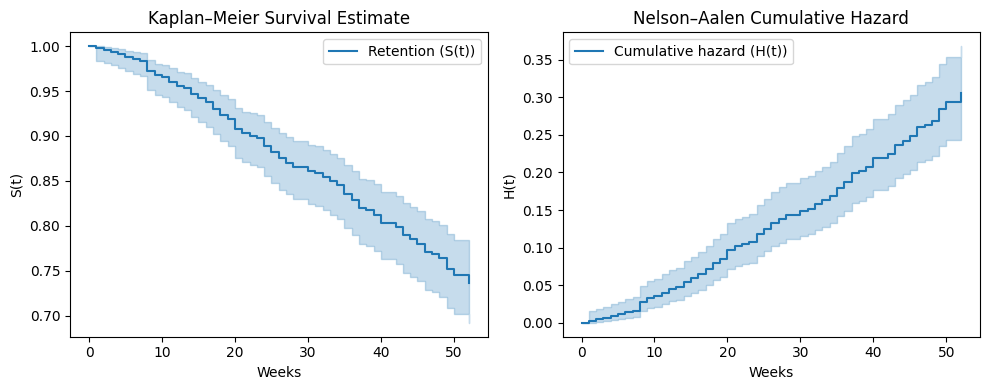

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.datasets import load_rossi

# Load dataset (time to re-arrest; we use it like "time to churn")
rossi = load_rossi()
T = rossi["week"]        # observed time
E = rossi["arrest"]      # event flag 1/0

# Kaplan-Meier (survival estimate)
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label="Retention (S(t))")

# Nelson-Aalen (cumulative hazard)
naf = NelsonAalenFitter()
naf.fit(T, event_observed=E, label="Cumulative hazard (H(t))")

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier Survival Estimate")
plt.xlabel("Weeks")
plt.ylabel("S(t)")

plt.subplot(1,2,2)
naf.plot_cumulative_hazard(ci_show=True)
plt.title("Nelson–Aalen Cumulative Hazard")
plt.xlabel("Weeks")
plt.ylabel("H(t)")
plt.tight_layout()
plt.show()

## 8. Marketing Interpretation

- **Survival Curve** answers: After X weeks, what % are still retained?
- **Cumulative hazard** grows when risk accumulates; steep climbs = high churn/upgrade activity.

## 9. **Math (Optional)**

### 9.1 **PDF, CDF, Survival functions**

- **PDF (Probability Density Function):**  
  $f(t)$ gives the likelihood that the event occurs *exactly* at time $t$.

- **CDF (Cumulative Distribution Function):**  
  $F(t) = P(T \le t) = \int_0^t f(u)\,du$
  gives the probability that the event has occurred *by* time $t$.

- **Survival Function:**  
  $S(t) = P(T > t) = 1 - F(t)$ 
  gives the probability of *surviving beyond* time $t$.

---

### 2. **Hazard Function**

The **hazard function** measures the *instantaneous risk* of the event happening at time \( t \), given survival up to that point.

It is defined as:

$$
h(t) = \lim_{\Delta t \to 0} \frac{P(t \le T < t+\Delta t \mid T \ge t)}{\Delta t}
$$

Expanding the conditional probability:

$$
P(t \le T < t+\Delta t \mid T \ge t) = \frac{P(t \le T < t+\Delta t)}{P(T \ge t)}
$$

The numerator is approximately \( f(t)\Delta t \) and the denominator is \( S(t) \), so:

$$
\boxed{h(t) = \frac{f(t)}{S(t)}}
$$

This means:  
> Hazard = (chance of failing now) / (chance of being alive till now)

---

### 9.3 **Connecting Hazard and Survival**

From $S'(t) = -f(t)$ and $f(t) = h(t)S(t)$, we get:

$$
\frac{dS(t)}{dt} = -h(t)S(t)
$$

Separate and integrate:

$$
\frac{1}{S(t)}\frac{dS(t)}{dt} = -h(t)
$$

$$
\int_0^t \frac{S'(u)}{S(u)}du = -\int_0^t h(u)du
$$

$$
\ln S(t) = -\int_0^t h(u)du
$$

Taking exponentials:

$$
\boxed{S(t) = e^{-\int_0^t h(u)\,du}}
$$

---

### 9.4 **Summary of Key Relationships**

| Function | Formula | Meaning |
|-----------|----------|---------|
| PDF | $f(t) = \dfrac{dF(t)}{dt} = h(t)S(t)$ | Likelihood of event at time $t$|
| CDF | $F(t) = 1 - S(t)$) | Probability event has occurred by $t$ |
| Survival | $S(t) = e^{-\int_0^t h(u)\,du}$ | Probability of surviving beyond $t$ |
| Hazard | $h(t) = \dfrac{f(t)}{S(t)}$ | Instantaneous risk at time $t$ |
| Cumulative Hazard | $H(t) = \int_0^t h(u)\,du = -\ln S(t)$ | Total accumulated risk up to $t$ |

---

**In short:**  
$$
f(t) \leftrightarrow F(t) \leftrightarrow S(t) \leftrightarrow h(t)
$$
All describe the *same time-to-event distribution* from different viewpoints —  
the **PDF** tells you “when”, the **Survival** tells you “how long”, and the **Hazard** tells you “how risky”.


